In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [3]:
import FinanceDataReader as fdr

In [106]:
# Apple(AAPL), 애플.
apple = fdr.DataReader('AAPL', "2000-01-01")

In [107]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5426 entries, 2000-01-03 to 2021-07-27
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5426 non-null   float64
 1   Open    5426 non-null   float64
 2   High    5426 non-null   float64
 3   Low     5426 non-null   float64
 4   Volume  5426 non-null   float64
 5   Change  5426 non-null   float64
dtypes: float64(6)
memory usage: 296.7 KB


In [108]:
# date 정보 년 월 일로 분할.
apple['Year'] = apple.index.year
apple['Month'] = apple.index.month
apple['Day'] = apple.index.day
apple["Year"].head()

Date
2000-01-03    2000
2000-01-04    2000
2000-01-05    2000
2000-01-06    2000
2000-01-07    2000
Name: Year, dtype: int64

Text(0, 0.5, 'price')

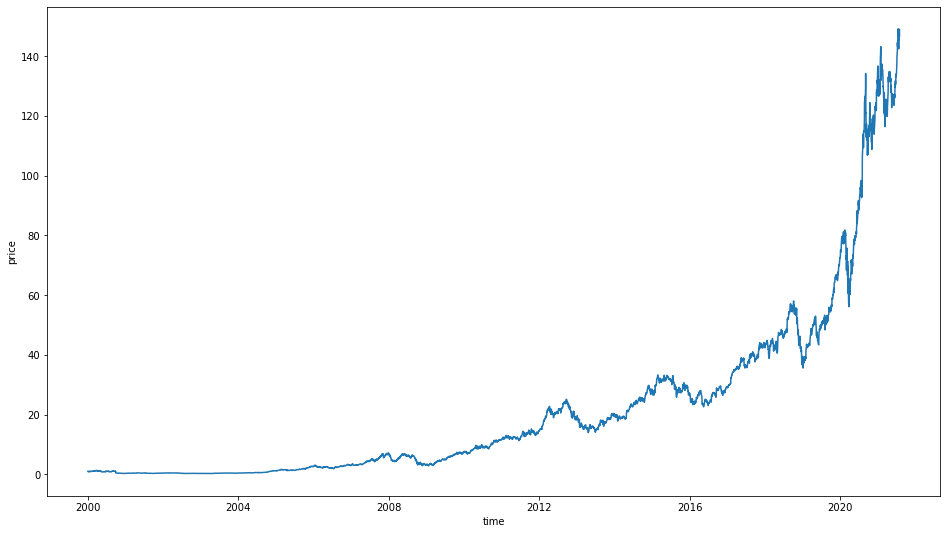

In [109]:
# 모든 기간 Close데이터 시각화.
plt.figure(figsize=(16, 9))
sns.lineplot(y=apple['Close'], x=apple.index)
plt.xlabel('time')
plt.ylabel('price')

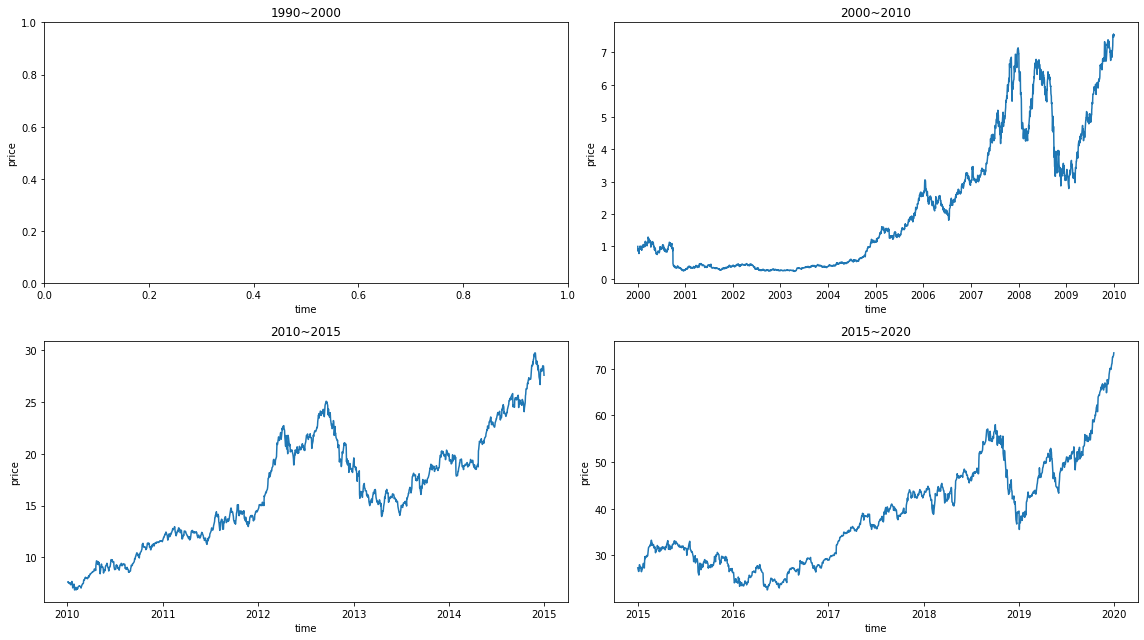

In [110]:
# 시각화2.
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = apple.loc[(apple.index > time_steps[i][0]) & (apple.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [111]:
# 전처리.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 스케일을 적용할 column을 정의.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# 스케일 후 columns
scaled = scaler.fit_transform(apple[scale_cols])
scaled

array([[0.00476446, 0.00507546, 0.00460954, 0.00517056, 0.06716027],
       [0.00496578, 0.00500868, 0.00454176, 0.00463336, 0.06390069],
       [0.00469736, 0.00500868, 0.00467733, 0.00470051, 0.09997253],
       ...,
       [0.98859214, 0.99158541, 0.99437364, 0.99603814, 0.00432716],
       [0.99328949, 0.99893148, 1.        , 0.9989256 , 0.00445976],
       [0.998725  , 0.99452384, 0.98522234, 0.98401826, 0.0088424 ]])

In [112]:
# 정규화 된걸 새로 저장.
apple = pd.DataFrame(scaled, columns=scale_cols)

In [113]:
# train / test 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(apple.drop('Close', 1), apple['Close'], test_size=0.2, random_state=0, shuffle=False)

In [114]:
x_train.shape, y_train.shape

((4340, 4), (4340,))

In [115]:
display(x_train)
display(y_train)

,Open,High,Low,Volume
0,0.004764,0.005075,0.004610,0.067160
1,0.004966,0.005009,0.004542,0.063901
2,0.004697,0.005009,0.004677,0.099973
3,0.004832,0.004808,0.004203,0.098573
4,0.004228,0.004408,0.004203,0.057000
...,...,...,...,...
4335,0.234868,0.238881,0.236781,0.012723
4336,0.239498,0.239615,0.241120,0.010458
4337,0.240370,0.239615,0.241662,0.006138
4338,0.239565,0.239281,0.240781,0.005301


0       0.005171
1       0.004633
2       0.004701
3       0.004163
4       0.004432
          ...   
4335    0.239860
4336    0.240398
4337    0.240062
4338    0.239592
4339    0.239659
Name: Close, Length: 4340, dtype: float64

In [116]:
# TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성
import tensorflow as tf

In [117]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [118]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [119]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋.
train_data_apple = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data_apple = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [120]:
# 데이터셋의 구성 확인.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data_apple.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [121]:
# 모델 구축
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(32, dropout=0.1 ,activation='tanh'),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(1),
])

In [122]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 20, 32)            192       
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


In [123]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber() 사용.
loss = 'mean_squared_error'
optimizer = Adam(0.0005)
model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

In [124]:
# earlystopping은 10번의 epoch통안 val_loss 개선이 없으면 학습을 멈춤.
# earlystopping = EarlyStopping(monitor='val_loss', patience=10)

# val_loss 기준 체크포인터 생성.
# filename = os.path.join('tmp', 'ckeckpointer.ckpt')
# checkpoint = ModelCheckpoint(filename, 
#                              save_weights_only=True, 
#                              save_best_only=True, 
#                              monitor='val_loss', 
#                              verbose=1)

In [125]:
# 실제 학습.
history = model.fit(train_data_apple, 
                    validation_data=(test_data_apple), 
                    epochs=50)

Epoch 1/50
135/135 [==============================] - 3s 20ms/step - loss: 4.9383e-05 - mse: 4.9383e-05 - val_loss: 0.0332 - val_mse: 0.0297
Epoch 2/50
135/135 [==============================] - 1s 6ms/step - loss: 2.8514e-05 - mse: 2.8514e-05 - val_loss: 0.0285 - val_mse: 0.0254
Epoch 3/50
135/135 [==============================] - 1s 6ms/step - loss: 2.6082e-05 - mse: 2.6082e-05 - val_loss: 0.0300 - val_mse: 0.0268
Epoch 4/50
135/135 [==============================] - 1s 6ms/step - loss: 2.2206e-05 - mse: 2.2206e-05 - val_loss: 0.0288 - val_mse: 0.0257
Epoch 5/50
135/135 [==============================] - 1s 6ms/step - loss: 2.4531e-05 - mse: 2.4531e-05 - val_loss: 0.0310 - val_mse: 0.0277
Epoch 6/50
135/135 [==============================] - 1s 6ms/step - loss: 2.2909e-05 - mse: 2.2909e-05 - val_loss: 0.0275 - val_mse: 0.0245
Epoch 7/50
135/135 [==============================] - 1s 6ms/step - loss: 2.0015e-05 - mse: 2.0015e-05 - val_loss: 0.0253 - val_mse: 0.0225
Epoch 8/50
135/135 

In [126]:
# 모델 예측.
pred_apple = model.predict(test_data_apple)

In [127]:
pred_apple.shape

(1066, 1)

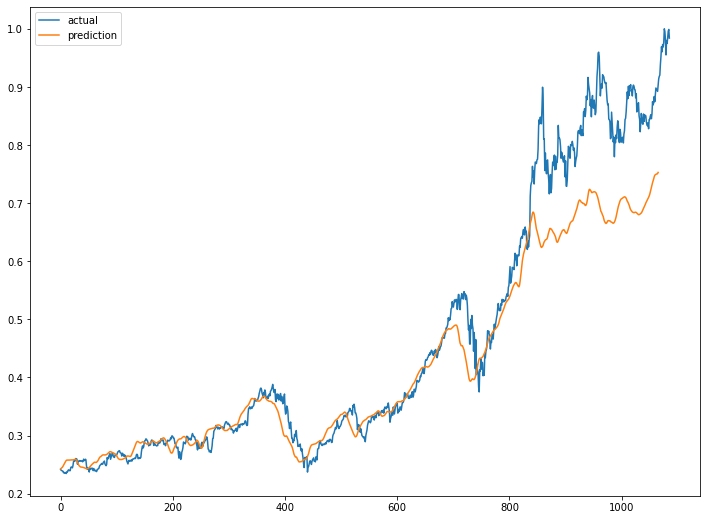

In [128]:
# 예측 데이터 시각화.
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test), label='actual')
plt.plot(pred_apple, label='prediction')
plt.legend()
plt.show()

# 애플 데이터로 학습된 모델로 삼성전자 주가 예측

In [129]:

samsung = fdr.DataReader('005930',"2000-01-01")

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled = scaler.fit_transform(samsung[scale_cols])
samsung = pd.DataFrame(scaled, columns=scale_cols)

In [130]:
_,samsung_x,_, samsung_y = train_test_split(samsung.drop('Close', 1), samsung['Close'], test_size=0.99, random_state=0, shuffle=False)

In [131]:
samsung_x

,Open,High,Low,Volume
53,0.063123,0.061364,0.062682,0.009950
54,0.066002,0.065083,0.065698,0.019263
55,0.071761,0.067975,0.069274,0.014385
56,0.069989,0.073554,0.069050,0.019991
57,0.077076,0.072727,0.074860,0.015001
...,...,...,...,...
5322,0.874862,0.824380,0.881564,0.139733
5323,0.882614,0.825413,0.884916,0.100756
5324,0.879291,0.821281,0.880447,0.111188
5325,0.877076,0.820248,0.877095,0.126544


In [132]:
samsung_data = windowed_dataset(samsung_y, WINDOW_SIZE, BATCH_SIZE, False)

print(samsung_data)

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float32, tf.float32)>


In [133]:
pred_samsung = model.predict(samsung_data)
print(pred_samsung.mean())

0.22465536


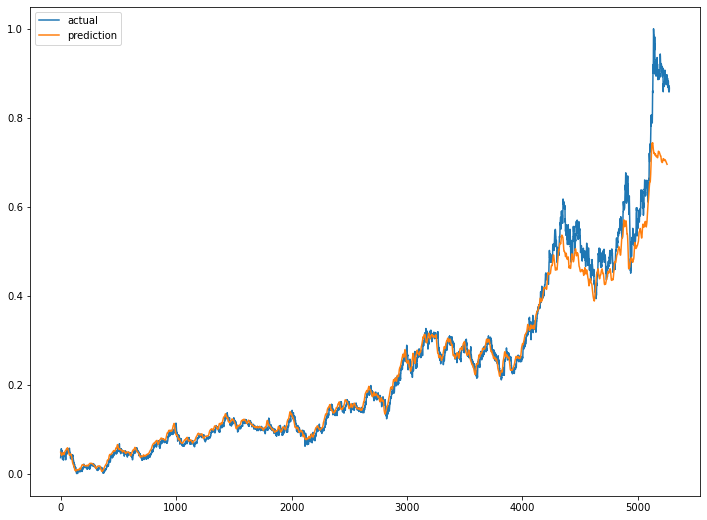

In [134]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(samsung_y), label='actual')
plt.plot(pred_samsung, label='prediction')
plt.legend()
plt.show()